In [ ]:
%pip install cantera

# Imports, constants, same std_atm from previous code base, cycle phases

In [ ]:
import math
import numpy as np
import pandas as pd

# Physical constants
g0   = 9.80665           # m/s^2
Rair = 287.052874        # J/(kg·K)
gamma_air_sea = 1.4

LHV_H2 = 120e6
f_st   = 0.029

# -------- 1976 US Standard Atmosphere (piecewise, up to ~86 km) --------
def std_atm(h_m):
    """
    Returns (T [K], p [Pa], rho [kg/m^3], a [m/s]) at geometric altitude h_m.
    ISA 1976, piecewise up to 32 km (covers our max 20.4 km).
    """
    # 0-11 km, 11-20 km (isothermal), 20-32 km
    layers = [
        (0.0,     288.15, 101325.0,    -0.0065),
        (11000.0, 216.65, 22632.06,     0.0    ),
        (20000.0, 216.65, 5474.889,     0.001  ),
    ]
    h = h_m
    if h < 0: h = 0.0
    if h <= 11000.0:
        T0, p0, L = layers[0][1], layers[0][2], layers[0][3]
        T = T0 + L*h
        p = p0*(T/T0)**(-g0/(L*Rair))
    elif h <= 20000.0:
        T1, p1 = layers[1][1], layers[1][2]
        T = T1
        p = p1*math.exp(-g0*(h-11000.0)/(Rair*T1))
    else:
        T2, p2, L2 = layers[2][1], layers[2][2], layers[2][3]
        T = T2 + L2*(h-20000.0)
        p = p2*(T/T2)**(-g0/(L2*Rair))
    rho = p/(Rair*T)
    a = math.sqrt(1.4*Rair*T)
    return T, p, rho, a

# Phase table (use midpoints of provided ranges)

def mid(a, b): return 0.5*(a+b)

# ---- Optional: keep decel on ~constant dynamic pressure corridor ----
USE_CONST_Q = False
Q_TARGET_PA = 45_000.0  # ~45 kPa (pick 40–50 kPa band as desired)

def find_alt_for_q(M, q_target, h_lo_kft=25.0, h_hi_kft=70.0, tol=5.0):
    """
    Rough 1D search for altitude that gives target q at a given Mach.
    Returns altitude in meters. tol is Pa tolerance for q.
    """
    h_lo = h_lo_kft*0.3048*1000
    h_hi = h_hi_kft*0.3048*1000
    for _ in range(40):
        h_mid = 0.5*(h_lo + h_hi)
        T, p, rho, a = std_atm(h_mid)
        V = M*a
        q = 0.5*rho*V*V
        if q > q_target:
            # too much dynamic pressure → go higher
            h_lo = h_mid
        else:
            h_hi = h_mid
        if abs(q - q_target) < tol:
            break
    return h_mid

# Helper to choose altitude for decel legs
def decel_alt(M_low, M_high):
    Mmid = mid(M_low, M_high)
    if USE_CONST_Q:
        return find_alt_for_q(Mmid, Q_TARGET_PA)
    # fallback: linear mid of original altitude bands
    return mid(60.0, 67.0)*0.3048*1000 if Mmid > 5.0 else mid(40.0, 60.0)*0.3048*1000

phases = [
    ("Takeoff/Climb",             mid(0.0,0.9),    mid(0.0,25.0)*0.3048*1000,  "Turbojet"),
    ("Acceleration A",            mid(0.9,2.5),    mid(25.0,40.0)*0.3048*1000, "Turbojet+Ramjet"),  # hand-off by ~M2.5
    ("Acceleration B",            mid(2.5,5.0),    mid(40.0,60.0)*0.3048*1000, "Ramjet"),
    ("High-Mach Cruise",          mid(5.0,6.5),    mid(60.0,67.0)*0.3048*1000, "Scramjet"),
    ("Decel A (SJ throttle→cut)", mid(5.5,6.5),    decel_alt(5.5,6.5),         "Scramjet"),        # throttle down / cut by ~M5.5
    ("Decel B (RJ fuel/drag)",    mid(3.0,5.5),    decel_alt(3.0,5.5),         "Ramjet"),          # low-phi → fuel-off as needed
    ("Decel C Transition",        mid(2.5,3.0),    mid(40.0,45.0)*0.3048*1000, "Ramjet+Turbojet"), # relight window for TJ
    ("Approach/Descent",          mid(0.9,2.5),    mid(25.0,40.0)*0.3048*1000, "Turbojet"),
    ("Landing",                   mid(0.0,0.9),    mid(0.0,25.0)*0.3048*1000,  "Turbojet"),
]

# Reference inlet sizes based on Concorde and SR71 - info from ChatGPT, not sure if it's accurate
inlet_catalog = {
    "Concorde_like": {"diameter_m": 1.35, "count": 4},
    "SR71_like":     {"diameter_m": 1.83, "count": 2},
}

# Vehicle stats from previous code
m_total = 40_000.0
m_fuel  = 17_600.0
fuel_fraction = m_fuel / m_total
print(f"Fuel fraction = {fuel_fraction:.3f}")
print("Revised schedule loaded. Toggle USE_CONST_Q to hold q during decel.")

Fuel fraction = 0.440
Revised schedule loaded. Toggle USE_CONST_Q to hold q during decel.


# Temp dependent properties, inlet recover, default values

In [ ]:
def cp_air(T):
    t = T/1000.0
    return (1003.5 + 0.1*(T-300.0) + 0.00004*(T-300.0)**2)

def gamma_air(T):
    cp = cp_air(T)
    R  = Rair
    cv = cp - R
    return cp/cv

# Isentropic helper relations
def Tt_from_T_M(T, M, gamma):
    return T*(1.0 + 0.5*(gamma-1.0)*M*M)

def pt_over_p_from_M(M, gamma):
    return (1.0 + 0.5*(gamma-1.0)*M*M)**(gamma/(gamma-1.0))

def ideal_inlet_recovery(M):
    """Ideal adiabatic diffuser total pressure recovery (no shocks) — purely isentropic."""
    g = 1.4
    return 1.0 / pt_over_p_from_M(M, g) * pt_over_p_from_M(0.0, g)  # =1, placeholder for structure

_inlet_rec_points = [
    (0.0,  0.995),
    (0.5,  0.992),
    (2.0,  0.980),
    (3.0,  0.960),
    (4.0,  0.940),
    (5.0,  0.920),
    (6.0,  0.900),
    (7.0,  0.880),
]
def inlet_recovery(M):
    xs, ys = zip(*_inlet_rec_points)
    return float(np.interp(M, xs, ys))

def inlet_adiabatic_eff(M):
    # This keeps values in ~[0.88, 0.98] across our envelope.
    rec = inlet_recovery(M)
    return min(0.98, max(0.88, 0.85 + 0.15*(rec - 0.88)/(0.12+1e-9)))

Tt4_turbojet = 1800.0
Tt4_ramjet   = 2400.0
Tt4_scramjet = 2300.0

pi_c      = 15.0           # compressor pressure ratio - from previous code
eta_pc    = 0.90           # compressor polytropic eff - assumed
eta_pt    = 0.90           # turbine polytropic eff - assumed
comb_dpt  = 0.05           # combustor total pressure loss - assumed
eta_b     = 0.99           # burner efficiency - assumed
eta_noz   = 0.97           # nozzle efficiency - assumed
loss_rj   = 0.05           # ramjet combustor pressure loss - assumed
loss_sj   = 0.15           # scramjet (isolator+comb+misc) total pressure loss - assumed

print("Cell 2 ready.")


Cell 2 ready.


# Inlet/nozzle functions


In [ ]:
def inlet_block(T0, p0, M0):
    g0 = gamma_air(T0)
    Tt0 = Tt_from_T_M(T0, M0, g0)
    pt0 = p0 * pt_over_p_from_M(M0, g0)
    rec = inlet_recovery(M0)
    pt2 = pt0 * rec
    Tt2 = Tt0  # (assume adiabatic diffuser)
    return {"Tt0":Tt0, "pt0":pt0, "Tt2":Tt2, "pt2":pt2,
            "eta_inlet": inlet_adiabatic_eff(M0), "recovery": rec}

def nozzle_cf_ideally_expanded(pt_chamber, pa, gamma, eta_noz=0.97):
    term = (2*gamma*gamma/(gamma-1.0)) * (2.0/(gamma+1.0))**((gamma+1.0)/(gamma-1.0)) \
           * (1.0 - (pa/pt_chamber)**((gamma-1.0)/gamma))
    term = max(term, 0.0)
    return math.sqrt(term) * math.sqrt(eta_noz)

print("Cell 3 ready.")


Cell 3 ready.


# Turbojet cycle

In [ ]:
def turbojet_cycle(T0, p0, M0):
    # Inlet to station 2
    ib = inlet_block(T0, p0, M0)
    Tt2, pt2 = ib["Tt2"], ib["pt2"]

    # Compressor 2 -> 3
    g_c = gamma_air(Tt2)
    tau_c = (pi_c)**((g_c-1.0)/(g_c*eta_pc))
    Tt3 = Tt2 * tau_c
    pt3 = pt2 * pi_c
    if Tt3 >= Tt4_turbojet:
      return {
        "engine":"Turbojet","T0":T0,"p0":p0,"M0":M0,
        "Tt2":Tt2,"pt2":pt2,"Tt3":Tt3,"pt3":pt3,
        "Tt4":Tt4_turbojet,"pt4":pt3*(1.0 - comb_dpt),
        "Tt5":Tt4_turbojet,"pt5":pt3*(1.0 - comb_dpt),
        "gamma_e": gamma_air(Tt4_turbojet),
        "pi_inlet": ib["pt2"]/ib["pt0"], "pi_comp": pt3/pt2, "pi_comb": (1.0 - comb_dpt),
        "pi_turb": 1.0, "pi_total": (ib["pt2"]/ib["pt0"])*(pt3/pt2)*(1.0 - comb_dpt),
        "eta_inlet": ib["eta_inlet"], "recov": ib["recovery"],
      }


    # Combustor 3 -> 4 (to target Tt4)
    Tt4 = Tt4_turbojet
    pt4 = pt3 * (1.0 - comb_dpt)
    g4  = gamma_air(Tt4)

    # Turbine 4 -> 5 : supplies compressor work (neglect mech losses per your "ideal losses none")
    cp2 = cp_air(Tt2)
    cp3 = cp_air(Tt3)
    cp4 = cp_air(Tt4)
    cp_c_avg = 0.5*(cp2 + cp3)
    work_comp_per_kg = cp_c_avg*(Tt3 - Tt2)

    cp_t_avg = cp_air(0.5*(Tt4))
    dT_turb  = work_comp_per_kg / max(cp_t_avg,1e-6)
    Tt5_ideal = Tt4 - dT_turb
    g_t = gamma_air(0.5*(Tt4+Tt5_ideal))
    tau_t = Tt5_ideal/Tt4
    pi_t = (tau_t)**(g_t*eta_pt/(g_t-1.0))
    pt5 = pt4 * pi_t
    Tt5 = Tt5_ideal

    # Nozzle: 5 -> e (perfect expansion to pa)
    pi_inlet   = ib["pt2"]/ib["pt0"]
    pi_comp    = pt3/pt2
    pi_comb    = pt4/pt3
    pi_turb    = pt5/pt4
    pi_noz     = None
    pi_total   = (ib["pt2"]/ib["pt0"]) * pi_comp * (pt4/pt3) * (pt5/pt4)

    out = {
        "engine":"Turbojet",
        "T0":T0, "p0":p0, "M0":M0,
        "Tt2":Tt2, "pt2":pt2,
        "Tt3":Tt3, "pt3":pt3,
        "Tt4":Tt4, "pt4":pt4,
        "Tt5":Tt5, "pt5":pt5,
        "gamma_e": gamma_air(Tt5),
        "pi_inlet":pi_inlet, "pi_comp":pi_comp, "pi_comb":pi_comb, "pi_turb":pi_turb,
        "pi_total":pi_total,
        "eta_inlet": ib["eta_inlet"], "recov": ib["recovery"],
    }
    return out

print("Cell 4 ready.")


Cell 4 ready.


# Ramjet Cycle


In [ ]:
def ramjet_cycle(T0, p0, M0):
    ib = inlet_block(T0, p0, M0)
    Tt2, pt2 = ib["Tt2"], ib["pt2"]
    # No compressor
    Tt3, pt3 = Tt2, pt2
    # Combustor to target Tt4
    Tt4 = Tt4_ramjet
    pt4 = pt3*(1.0 - loss_rj)
    # No turbine
    Tt5, pt5 = Tt4, pt4

    pi_inlet = ib["pt2"]/ib["pt0"]
    pi_comp  = 1.0
    pi_comb  = pt4/pt3
    pi_turb  = 1.0
    pi_total = pi_inlet * pi_comp * pi_comb * pi_turb

    out = {
        "engine":"Ramjet",
        "T0":T0, "p0":p0, "M0":M0,
        "Tt2":Tt2, "pt2":pt2,
        "Tt3":Tt3, "pt3":pt3,
        "Tt4":Tt4, "pt4":pt4,
        "Tt5":Tt5, "pt5":pt5,
        "gamma_e": gamma_air(Tt5),
        "pi_inlet":pi_inlet, "pi_comp":pi_comp, "pi_comb":pi_comb, "pi_turb":pi_turb,
        "pi_total":pi_total,
        "eta_inlet": ib["eta_inlet"], "recov": ib["recovery"],
    }
    return out

print("Cell 5 ready.")


Cell 5 ready.


# Scramjet Cycle


In [ ]:
def scramjet_cycle(T0, p0, M0):
    ib = inlet_block(T0, p0, M0)
    Tt2, pt2 = ib["Tt2"], ib["pt2"]
    # Highly compressive inlet/isolator + combustor combined total-pressure loss - assumed
    Tt4 = Tt4_scramjet
    pt5 = pt2 * (1.0 - loss_sj)
    Tt5 = Tt4

    pi_inlet = ib["pt2"]/ib["pt0"]
    pi_comp  = 1.0
    pi_comb  = (1.0 - loss_sj)   # rolled up
    pi_turb  = 1.0
    pi_total = pi_inlet * pi_comp * pi_comb * pi_turb

    out = {
        "engine":"Scramjet",
        "T0":T0, "p0":p0, "M0":M0,
        "Tt2":Tt2, "pt2":pt2,
        "Tt3":Tt2, "pt3":pt2,
        "Tt4":Tt4, "pt4":pt5,    # we label pt4 about pt5 since no turbomachinery segment
        "Tt5":Tt5, "pt5":pt5,
        "gamma_e": gamma_air(Tt5),
        "pi_inlet":pi_inlet, "pi_comp":pi_comp, "pi_comb":pi_comb, "pi_turb":pi_turb,
        "pi_total":pi_total,
        "eta_inlet": ib["eta_inlet"], "recov": ib["recovery"],
    }
    return out

print("Cell 6 ready.")


Cell 6 ready.


# Execution

In [ ]:
def far_from_Tt_rise(Tt_in, Tt_out, eta_b=0.99):
    cp_avg = cp_air(0.5*(Tt_in+Tt_out))
    q_req  = cp_avg*(Tt_out - Tt_in)
    f = max(0.0, q_req / (eta_b*LHV_H2))
    return f

def jet_velocity_ideally_expanded(Tt, pt, pa, gamma, eta_noz=0.97):
    Te = Tt / (pt/pa)**((gamma-1.0)/gamma)
    cp_e = cp_air(0.5*(Tt+Te))
    Ve = math.sqrt(max(0.0, 2.0*eta_noz*cp_e*(Tt - Te)))
    return Ve, Te

def overall_efficiencies(T0, p0, M0, Tt_e, pt_e, pa, eta_noz=0.97):
    a0 = math.sqrt(gamma_air(T0)*Rair*T0)
    V0 = M0*a0
    g_e = gamma_air(Tt_e)
    Ve, Te = jet_velocity_ideally_expanded(Tt_e, pt_e, pa, g_e, eta_noz)
    return V0, Ve, Te

rows_ambient = []
rows_exit    = []
rows_press   = []
rows_perf    = []

for name, Mmid, hmid, mode in phases:
    T, p, rho, a = std_atm(hmid)
    # Ambient table
    rows_ambient.append({
        "Phase": name,
        "Mode": mode,
        "h (m)": round(hmid,1),
        "h (kft)": round(hmid/0.3048/1000,2),
        "M": round(Mmid,3),
        "T (K)": round(T,2),
        "p (Pa)": round(p,1),
        "rho (kg/m^3)": round(rho,6),
        "a (m/s)": round(a,2),
        "V (m/s)": round(Mmid*a,2),
    })

    # engines that appear in this phase
    engines_here = []
    if "Turbojet" in mode: engines_here.append("Turbojet")
    if "Ramjet"   in mode: engines_here.append("Ramjet")
    if "Scramjet" in mode: engines_here.append("Scramjet")

    for eng in engines_here:
        if eng=="Turbojet":
            out = turbojet_cycle(T, p, Mmid)
            Tt_in_comb = out["Tt3"]
        elif eng=="Ramjet":
            out = ramjet_cycle(T, p, Mmid)
            Tt_in_comb = out["Tt3"]
        else:
            out = scramjet_cycle(T, p, Mmid)
            Tt_in_comb = out["Tt3"]

        # (2) Exit temps
        rows_exit.append({
            "Phase": name, "Engine": eng,
            "Tt4 (K)": round(out["Tt4"],1),
            "Tt5/Te_total_node (K)": round(out["Tt5"],1),
        })

        # (4) Pressure analysis
        rows_press.append({
            "Phase": name, "Engine": eng,
            "pi_inlet": round(out["pi_inlet"],4),
            "pi_comp":  round(out["pi_comp"],4),
            "pi_comb":  round(out["pi_comb"],4),
            "pi_turb":  round(out["pi_turb"],4),
            "pi_total": round(out["pi_total"],4),
        })

        # (5) Inlet efficiency & nozzle Cf
        Cf = nozzle_cf_ideally_expanded(out["pt5"], p, out["gamma_e"], eta_noz)
        V0 = Mmid*math.sqrt(gamma_air(T)*Rair*T)
        Ve, Te = jet_velocity_ideally_expanded(out["Tt5"], out["pt5"], p, out["gamma_e"], eta_noz)
        f = far_from_Tt_rise(Tt_in_comb, out["Tt4"], eta_b)
        jet_power = 0.5*(Ve**2 - V0**2)
        fuel_power = f * LHV_H2
        eta_th = max(0.0, min(1.0, jet_power / max(fuel_power,1e-9)))
        eta_p = 0.0 if Ve <= V0 else (2*V0) / max(Ve + V0, 1e-9)
        eta_p = min(1.0, max(0.0, eta_p))
        eta_o  = eta_th * max(0.0, min(1.0, eta_p))
        spec_thrust = (1.0 + f)*Ve - V0
        mach = V0/a

        rows_perf.append({
            "Phase": name, "Engine": eng,
            "eta_inlet": round(out["eta_inlet"],3),
            "Nozzle Cf": round(Cf,4),
            "eta_th": round(eta_th,3),
            "eta_p":  round(eta_p,3),
            "eta_overall": round(eta_o,3),
            "f (FAR est)": round(f,5),
            "Ve (m/s)": round(Ve,1),
            "V0 (m/s)": round(V0,1),
            "Specific Thrust": round(spec_thrust,1),
            "Tt_in_comb (K)": round(Tt_in_comb,1),
            "Mach number": round(mach,3)
        })

# Print nicely
amb_df   = pd.DataFrame(rows_ambient)
exit_df  = pd.DataFrame(rows_exit)
press_df = pd.DataFrame(rows_press)
perf_df  = pd.DataFrame(rows_perf)

print("(1) Ambient Conditions by Phase")
display(amb_df)

print("(2) Engine Exit Temperatures (Tt4 and total-state into nozzle)")
display(exit_df.pivot(index="Phase", columns="Engine", values="Tt4 (K)").fillna(""))
display(exit_df.pivot(index="Phase", columns="Engine", values="Tt5/Te_total_node (K)").fillna(""))

print("(4) Pressure Analysis (π terms)")
display(press_df)

print("(5) Inlet efficiency and Nozzle Thrust Coefficient; (3) Thermal/Propulsive/Overall Efficiencies")
display(perf_df)

print("Cell 7 ready.")


(1) Ambient Conditions by Phase


,Phase,Mode,h (m),h (kft),M,T (K),p (Pa),rho (kg/m^3),a (m/s),V (m/s)
0,Takeoff/Climb,Turbojet,3810.0,12.5,0.45,263.38,63181.8,0.835679,325.34,146.40
1,Acceleration A,Turbojet+Ramjet,9906.0,32.5,1.70,223.76,26818.9,0.417537,299.87,509.78
2,Acceleration B,Ramjet,15240.0,50.0,3.75,216.65,11597.3,0.186481,295.07,1106.51
3,High-Mach Cruise,Scramjet,19354.8,63.5,5.75,216.65,6061.2,0.097463,295.07,1696.65
4,Decel A (SJ throttle→cut),Scramjet,19354.8,63.5,6.00,216.65,6061.2,0.097463,295.07,1770.42
5,Decel B (RJ fuel/drag),Ramjet,15240.0,50.0,4.25,216.65,11597.3,0.186481,295.07,1254.05
6,Decel C Transition,Ramjet+Turbojet,12954.0,42.5,2.75,216.65,16630.6,0.267416,295.07,811.44
7,Approach/Descent,Turbojet,9906.0,32.5,1.70,223.76,26818.9,0.417537,299.87,509.78
8,Landing,Turbojet,3810.0,12.5,0.45,263.38,63181.8,0.835679,325.34,146.40


(2) Engine Exit Temperatures (Tt4 and total-state into nozzle)


Engine,Ramjet,Scramjet,Turbojet
Phase,,,
Acceleration A,2400.0,,1800.0
Acceleration B,2400.0,,
Approach/Descent,,,1800.0
Decel A (SJ throttle→cut),,2300.0,
Decel B (RJ fuel/drag),2400.0,,
Decel C Transition,2400.0,,1800.0
High-Mach Cruise,,2300.0,
Landing,,,1800.0
Takeoff/Climb,,,1800.0


Engine,Ramjet,Scramjet,Turbojet
Phase,,,
Acceleration A,2400.0,,1337.4
Acceleration B,2400.0,,
Approach/Descent,,,1337.4
Decel A (SJ throttle→cut),,2300.0,
Decel B (RJ fuel/drag),2400.0,,
Decel C Transition,2400.0,,1076.2
High-Mach Cruise,,2300.0,
Landing,,,1443.9
Takeoff/Climb,,,1443.9


(4) Pressure Analysis (π terms)


,Phase,Engine,pi_inlet,pi_comp,pi_comb,pi_turb,pi_total
0,Takeoff/Climb,Turbojet,0.9923,15.0,0.95,0.4346,6.1452
1,Acceleration A,Turbojet,0.9824,15.0,0.95,0.3286,4.6004
2,Acceleration A,Ramjet,0.9824,1.0,0.95,1.0000,0.9333
3,Acceleration B,Ramjet,0.9450,1.0,0.95,1.0000,0.8977
4,High-Mach Cruise,Scramjet,0.9050,1.0,0.85,1.0000,0.7692
5,Decel A (SJ throttle→cut),Scramjet,0.9000,1.0,0.85,1.0000,0.7650
6,Decel B (RJ fuel/drag),Ramjet,0.9350,1.0,0.95,1.0000,0.8883
7,Decel C Transition,Turbojet,0.9650,15.0,0.95,0.1518,2.0872
8,Decel C Transition,Ramjet,0.9650,1.0,0.95,1.0000,0.9168
9,Approach/Descent,Turbojet,0.9824,15.0,0.95,0.3286,4.6004


(5) Inlet efficiency and Nozzle Thrust Coefficient; (3) Thermal/Propulsive/Overall Efficiencies


,Phase,Engine,eta_inlet,Nozzle Cf,eta_th,eta_p,eta_overall,f (FAR est),Ve (m/s),V0 (m/s),Specific Thrust,Tt_in_comb (K),Mach number
0,Takeoff/Climb,Turbojet,0.980,1.1659,0.447,0.236,0.106,0.01094,1093.5,146.5,958.9,649.7,0.450
1,Acceleration A,Turbojet,0.978,1.3809,0.568,0.584,0.332,0.00932,1237.0,510.7,737.9,834.7,1.703
2,Acceleration A,Ramjet,0.978,1.0526,0.290,0.569,0.165,0.01993,1283.8,510.7,798.7,354.7,1.703
3,Acceleration B,Ramjet,0.931,1.5806,0.584,0.747,0.436,0.01588,1858.5,1108.6,779.4,833.9,3.757
4,High-Mach Cruise,Scramjet,0.881,1.7518,0.655,0.921,0.604,0.00684,1991.3,1699.8,305.1,1667.9,5.761
5,Decel A (SJ throttle→cut),Scramjet,0.880,1.7660,0.661,0.939,0.621,0.00551,2005.0,1773.7,242.3,1796.9,6.011
6,Decel B (RJ fuel/drag),Ramjet,0.919,1.6428,0.616,0.791,0.487,0.01431,1922.0,1256.4,693.1,1009.5,4.258
7,Decel C Transition,Turbojet,0.956,1.4813,0.590,0.812,0.479,0.00532,1188.8,813.0,382.2,1268.1,2.755
8,Decel C Transition,Ramjet,0.956,1.3965,0.480,0.656,0.315,0.01833,1665.3,813.0,882.9,548.6,2.755
9,Approach/Descent,Turbojet,0.978,1.3809,0.568,0.584,0.332,0.00932,1237.0,510.7,737.9,834.7,1.703


Cell 7 ready.


# Net thrust calcs

In [ ]:
import pandas as pd
from math import pi

sigma_cap = 0.98

def inlet_area(d_m, count):
    return count * (pi*(d_m**2)/4.0)

families = {
    "Concorde_like (4×1.35m)": {"d": 1.35, "count": 4},
    "SR71_like (2×1.83m)":     {"d": 1.83, "count": 2},
}

net_rows = []
for name, Mmid, hmid, mode in phases:
    T, p, rho, a = std_atm(hmid)
    V = Mmid * a

    sub = perf_df[perf_df["Phase"]==name]

    for _, r in sub.iterrows():
        eng = r["Engine"]
        ST  = float(r["Specific Thrust"])
        for fam_name, meta in families.items():
            A = inlet_area(meta["d"], meta["count"])
            mdot = rho * V * A * sigma_cap
            Fnet = ST * mdot
            net_rows.append({
                "Phase": name,
                "Engine": eng,
                "Inlet family": fam_name,
                "rho (kg/m^3)": round(rho,4),
                "V (m/s)": round(V,1),
                "Area (m^2)": round(A,3),
                "m_dot (kg/s)": round(mdot,1),
                "Specific Thrust (m/s)": ST,
                "Net Thrust (N)": round(Fnet,0),
                "Net Thrust (kN)": round(Fnet/1000.0,2),
            })

net_thrust_df = pd.DataFrame(net_rows)
print("Net thrust by phase, engine, and inlet family")
display(net_thrust_df)
net_thrust_df.to_csv("net_thrust.csv")


Net thrust by phase, engine, and inlet family


,Phase,Engine,Inlet family,rho (kg/m^3),V (m/s),Area (m^2),m_dot (kg/s),Specific Thrust (m/s),Net Thrust (N),Net Thrust (kN)
0,Takeoff/Climb,Turbojet,Concorde_like (4×1.35m),0.8357,146.4,5.726,686.5,958.9,658278.0,658.28
1,Takeoff/Climb,Turbojet,SR71_like (2×1.83m),0.8357,146.4,5.260,630.7,958.9,604803.0,604.80
2,Acceleration A,Turbojet,Concorde_like (4×1.35m),0.4175,509.8,5.726,1194.3,737.9,881296.0,881.30
3,Acceleration A,Turbojet,SR71_like (2×1.83m),0.4175,509.8,5.260,1097.3,737.9,809704.0,809.70
4,Acceleration A,Ramjet,Concorde_like (4×1.35m),0.4175,509.8,5.726,1194.3,798.7,953911.0,953.91
5,Acceleration A,Ramjet,SR71_like (2×1.83m),0.4175,509.8,5.260,1097.3,798.7,876421.0,876.42
6,Acceleration B,Ramjet,Concorde_like (4×1.35m),0.1865,1106.5,5.726,1157.8,779.4,902389.0,902.39
7,Acceleration B,Ramjet,SR71_like (2×1.83m),0.1865,1106.5,5.260,1063.7,779.4,829084.0,829.08
8,High-Mach Cruise,Scramjet,Concorde_like (4×1.35m),0.0975,1696.6,5.726,927.8,305.1,283085.0,283.09
9,High-Mach Cruise,Scramjet,SR71_like (2×1.83m),0.0975,1696.6,5.260,852.5,305.1,260089.0,260.09


# Real exit static temps (not good)

In [ ]:
def Te_from_Ve_energy(Tt, Ve, eta_noz=0.97, tol=1e-6, maxit=50):

    target = 0.5*Ve*Ve/eta_noz

    # Start with constant-cp guess
    cp0 = cp_air(Tt)
    Te  = max(50.0, Tt - target/max(cp0,1e-6))  # initial guess

    def H(Tlow, Thigh, nseg=8):
        # integrate cp(T) from Tlow to Thigh via Simpson (piecewise)
        xs = np.linspace(Tlow, Thigh, nseg+1)
        cps = np.array([cp_air(x) for x in xs])
        # Simpson
        h = (Thigh - Tlow)/nseg
        S = cps[0] + cps[-1] + 4*np.sum(cps[1:-1:2]) + 2*np.sum(cps[2:-1:2])
        return 0.5*h*S

    for _ in range(maxit):
        # F(Te) = ∫_{Te}^{Tt} cp dT - target
        F = H(Te, Tt) - target
        if abs(F) < tol:
            break
        # dF/dTe = -cp(Te)
        dF = -cp_air(Te)
        step = -F / max(dF, 1e-9)
        # Dampen step to keep Te physical
        step = np.clip(step, -200.0, 200.0)
        Te_new = Te + step
        # keep within (small, Tt)
        Te = min(max(50.0, Te_new), Tt - 1e-6)
    return Te

# Find, for each engine, the phase with the highest freestream Mach where it operates
engine_types = ["Turbojet", "Ramjet", "Scramjet"]
selection = []
for eng in engine_types:
    # Filter phases where this engine appears
    valid = [(name, Mmid, hmid, mode) for (name, Mmid, hmid, mode) in phases if eng in mode]
    if not valid:
        continue
    # Pick the one with max M
    pick = max(valid, key=lambda r: r[1])
    selection.append((eng,)+pick)  # (engine, phase_name, M, h, mode)

rows = []
for eng, name, Mmid, hmid, mode in selection:
    # Ambient
    T, p, rho, a = std_atm(hmid)

    # Recompute engine cycle at this phase (for Tt5, pt5)
    if eng=="Turbojet":
        out = turbojet_cycle(T, p, Mmid)
        Tt_in_comb = out["Tt3"]
    elif eng=="Ramjet":
        out = ramjet_cycle(T, p, Mmid)
        Tt_in_comb = out["Tt3"]
    else:
        out = scramjet_cycle(T, p, Mmid)
        Tt_in_comb = out["Tt3"]

    # Pull Ve from perf_df for the exact phase+engine row already computed
    row_pf = perf_df[(perf_df["Phase"]==name) & (perf_df["Engine"]==eng)]
    if len(row_pf)==0:
        # compute Ve directly if not found (shouldn't happen)
        Ve, Te_iso_tmp = jet_velocity_ideally_expanded(out["Tt5"], out["pt5"], p, out["gamma_e"], eta_noz)
    else:
        Ve = float(row_pf["Ve (m/s)"].iloc[0])

    # (A) Energy-based Te using Ve and cp(T)
    Te_energy = Te_from_Ve_energy(out["Tt5"], Ve, eta_noz)

    # (B) Isentropic Te (perfect expansion pe=pa)
    gamma_e = out["gamma_e"]
    Te_isen = out["Tt5"] / (out["pt5"]/p)**((gamma_e-1.0)/gamma_e)

    rows.append({
        "Engine": eng,
        "Phase @ max M": name,
        "M": round(Mmid,3),
        "h (kft)": round(hmid/0.3048/1000,2),
        "Tt5 (K)": round(out["Tt5"],1),
        "pt5 (kPa)": round(out["pt5"]/1000.0,2),
        "pa (kPa)": round(p/1000.0,3),
        "Ve (m/s)": round(Ve,1),
        "Te (energy) (K)": round(Te_energy,1),
        "Te (isentropic) (K)": round(Te_isen,1),
        "|ΔTe| (K)": round(abs(Te_energy - Te_isen),2),
    })

Te_df = pd.DataFrame(rows)
print("Real exit static temperatures inferred from computed Ve at each engine's max-speed phase")
display(Te_df)


Real exit static temperatures inferred from computed Ve at each engine's max-speed phase


,Engine,Phase @ max M,M,h (kft),Tt5 (K),pt5 (kPa),pa (kPa),Ve (m/s),Te (energy) (K),Te (isentropic) (K),|ΔTe| (K)
0,Turbojet,Decel C Transition,2.75,42.5,1076.2,870.45,16.631,1188.8,50.0,385.0,335.02
1,Ramjet,Decel B (RJ fuel/drag),4.25,50.0,2400.0,2140.93,11.597,1922.0,50.0,816.9,766.90
2,Scramjet,Decel A (SJ throttle→cut),6.00,63.5,2300.0,7117.10,6.061,2005.0,50.0,519.4,469.36


# Exit temps calcs (good, use this one)

In [ ]:
from math import pi

W  = 40_000.0 * g0
LD = 5.88
T_required = W / LD

families = {
    "Concorde_like (4×1.35m)": {"d": 1.35, "count": 4},
    "SR71_like (2×1.83m)":     {"d": 1.83, "count": 2},
}
sigma_cap = 0.98

# Physics caps
f_max_global = 0.95 * f_st                 # <= stoichiometric - done on purpose, want to keep it in the lean regime to conserve fuel, also it prevents exit temps from getting too hgh
Tt4_cap = {"Turbojet": 1800.0, "Ramjet": 2400.0, "Scramjet": 2300.0}  # K

def inlet_area(d_m, count): return count * (pi*(d_m**2)/4.0)

def max_phase_for_engine(eng):
    cands = [(name, M, h, mode) for (name, M, h, mode) in phases if eng in mode]
    if not cands: return None
    name, M, h, mode = max(cands, key=lambda r: r[1])
    if eng=="Scramjet":
        name = "Hypersonic Cruise (Design)"
        M    = 6.5
        h    = mid(60.0,67.0)*0.3048*1000
        mode = "Scramjet"
    return (name, M, h, mode)

def Ve_Te_from_totals(Tt5, pt5, pa, eta_noz, nseg=16, eps=1e-9):
    """
    #old code
    ge = gamma_air(Tt5)
    Te_iso = Tt5 / (pt5/pa)**((ge-1.0)/ge)
    nseg = 16
    xs = np.linspace(Te_iso, Tt5, nseg+1)
    cps = np.array([cp_air(x) for x in xs])
    h = (Tt5-Te_iso)/nseg
    H_drop = 0.5*h*(cps[0] + cps[-1] + 4*np.sum(cps[1:-1:2]) + 2*np.sum(cps[2:-1:2]))
    Ve = (2.0*eta_noz*H_drop)**0.5
    """
    # new code with guard against negative h_drop formula
    # Guard ambient pressure
    pa = max(pa, eps)
    r = pt5 / pa

    # Need pt5 > pa for useful isentropic expansion to ambient
    if r <= 1.0 + 1e-12:   # small tolerance
        Te_iso = Tt5
        return 0.0, Te_iso

    # Isentropic static exit temperature to pa
    ge = gamma_air(Tt5)  # good enough; could also use mean(Tt5, Te_iso) in a refinement
    Te_iso = Tt5 / (r ** ((ge - 1.0) / ge))

    # Simpson setup
    if nseg % 2 == 1:
        nseg += 1
    h = (Tt5 - Te_iso) / nseg
    if h <= 0:
        # Degenerate interval -> no enthalpy drop
        return 0.0, Te_iso

    xs  = np.linspace(Te_iso, Tt5, nseg + 1)
    cps = np.array([cp_air(x) for x in xs])

    # Enthalpy drop: ∫_{Te_iso}^{Tt5} cp(T) dT
    H_drop = (h / 3.0) * (
        cps[0] + cps[-1] + 4.0 * np.sum(cps[1:-1:2]) + 2.0 * np.sum(cps[2:-1:2])
    )

    # Numeric safety
    if not np.isfinite(H_drop):
        H_drop = 0.0
    H_drop = max(H_drop, 0.0)

    Ve = (2.0 * eta_noz * H_drop) ** 0.5
    return Ve, Te_iso
    return Ve, Te_iso

def closure_factory(engine, T, p, M):
    g = gamma_air(T)
    a = (g*Rair*T)**0.5
    V0 = M*a
    Tt0 = T*(1 + 0.5*(g-1)*M*M)
    pt0 = p*(1 + 0.5*(g-1)*M*M)**(g/(g-1))
    rec = inlet_recovery(M)
    pt2 = pt0*rec
    Tt2 = Tt0

    if engine=="Turbojet":
        gc = gamma_air(Tt2)
        tau_c = (pi_c)**((gc-1)/(gc*eta_pc))
        Tt3 = Tt2 * tau_c
        pt3 = pt2 * pi_c
        pt4_nom = pt3 * (1.0 - comb_dpt)
        cp_c_avg = 0.5*(cp_air(Tt2)+cp_air(Tt3))
        Wc = cp_c_avg*(Tt3 - Tt2)

        def closure(f):
            cp_guess = cp_air(0.5*(Tt3 + (Tt3+800)))
            Tt4_raw = Tt3 + (f*eta_b*LHV_H2)/max(cp_guess,1e-6)
            Tt4 = min(Tt4_raw, Tt4_cap["Turbojet"])
            cp_t_avg = cp_air(0.5*Tt4)
            dTt = Wc/max(cp_t_avg,1e-6)
            Tt5 = max(1.0, Tt4 - dTt)
            gt  = gamma_air(0.5*(Tt4+Tt5))
            pi_t = (Tt5/Tt4)**(gt*eta_pt/(gt-1.0))
            pt5 = pt4_nom * pi_t
            Ve, Te_iso = Ve_Te_from_totals(Tt5, pt5, p, eta_noz)
            ST = (1.0+f)*Ve - V0
            return ST, Ve, Te_iso, Tt3, Tt4, Tt5, pt5, V0

    elif engine=="Ramjet":
        Tt3, pt3 = Tt2, pt2
        pt5_nom  = pt3*(1.0 - loss_rj)

        def closure(f):
            cp_guess = cp_air(0.5*(Tt3 + (Tt3+900)))
            Tt4_raw = Tt3 + (f*eta_b*LHV_H2)/max(cp_guess,1e-6)
            Tt4 = min(Tt4_raw, Tt4_cap["Ramjet"])
            Tt5, pt5 = Tt4, pt5_nom
            Ve, Te_iso = Ve_Te_from_totals(Tt5, pt5, p, eta_noz)
            ST = (1.0+f)*Ve - V0
            return ST, Ve, Te_iso, Tt3, Tt4, Tt5, pt5, V0

    else:  # Scramjet
        pt5_base = pt2*(1.0 - loss_sj)
        Tt3 = Tt2

        def closure(f):
            cp_guess = cp_air(0.5*(Tt3 + (Tt3+900)))
            Tt4_raw = Tt3 + (f*eta_b*LHV_H2)/max(cp_guess,1e-6)
            Tt4 = min(Tt4_raw, Tt4_cap["Scramjet"])
            Tt5, pt5 = Tt4, pt5_base
            Ve, Te_iso = Ve_Te_from_totals(Tt5, pt5, p, eta_noz)
            ST = (1.0+f)*Ve - V0
            return ST, Ve, Te_iso, Tt3, Tt4, Tt5, pt5, V0

    return closure

def solve_f(engine, T, p, M, family):
    # Mass flow and required specific thrust
    g = gamma_air(T)
    a = (g*Rair*T)**0.5
    A = inlet_area(family["d"], family["count"])
    rho = p/(Rair*T)
    mdot = rho * (M*a) * A * sigma_cap
    ST_req = T_required / max(mdot, 1e-9)   # required net specific thrust [m/s]

    # Build the flowpath closure at this flight condition
    closure = closure_factory(engine, T, p, M)

    # ---- Baseline (no fuel): compute Ve0 so ST_net(0) = 0 by construction ----
    ST0_raw, Ve0, Te0_iso, Tt3_0, Tt4_0, Tt5_0, pt5_0, V0 = closure(0.0)
    # ST0_raw is (1+0)*Ve0 - V0 = Ve0 - V0; we anchor to Ve0 so baseline net = 0

    # Bracket on [0, f_max_global]
    f_lo, f_hi = 0.0, f_max_global

    # Net ST at the upper bound
    ST_hi_raw, Ve_hi, *_ = closure(f_hi)
    ST_net_hi = (1.0 + f_hi)*Ve_hi - Ve0

    # If required ST is ~zero or negative, f=0 is sufficient
    if ST_req <= 1e-6:
        f_sol = 0.0
        ST_final_net = 0.0
        Ve, Te_iso, Tt3, Tt4, Tt5, pt5 = Ve0, Te0_iso, Tt3_0, Tt4_0, Tt5_0, pt5_0
        feasible = True

    # If even the capped fuel cannot reach the required net ST -> infeasible
    elif ST_net_hi < ST_req - 1e-6:
        f_sol = f_hi
        ST_raw, Ve, Te_iso, Tt3, Tt4, Tt5, pt5, _ = closure(f_sol)
        ST_final_net = (1.0 + f_sol)*Ve - Ve0
        feasible = False

    else:
        # Bisection on ST_net(f) - ST_req = 0
        lo, hi = f_lo, f_hi
        for _ in range(80):
            fm = 0.5*(lo + hi)
            ST_raw_m, Ve_m, *_rest = closure(fm)
            ST_net_m = (1.0 + fm)*Ve_m - Ve0
            if abs(ST_net_m - ST_req) < 1e-4:
                f_sol = fm
                Ve = Ve_m
                break
            if ST_net_m > ST_req:
                hi = fm
                Ve = Ve_m
            else:
                lo = fm
                Ve = Ve_m
        else:
            f_sol = 0.5*(lo + hi)
            ST_raw_m, Ve, *_ = closure(f_sol)

        # Get full state at the solved f
        ST_raw, Ve, Te_iso, Tt3, Tt4, Tt5, pt5, _ = closure(f_sol)
        ST_final_net = (1.0 + f_sol)*Ve - Ve0
        feasible = True

    # Energy-based Te equals isentropic Te here (perfect expansion assumption);
    # keep both fields for future non-ideal extensions.
    Te_energy = Te_iso

    return dict(
        feasible=feasible,
        f=f_sol,
        ST=ST_final_net,      # net specific thrust [m/s] = N·s/kg_air
        ST_req=ST_req,
        mdot=mdot,
        V0=V0,
        Ve=Ve,
        Ve0=Ve0,
        Te_iso=Te_iso,
        Te_energy=Te_energy,
        Tt3=Tt3,
        Tt4=Tt4,
        Tt5=Tt5,
        pt5=pt5
    )


rows = []
for eng in ["Turbojet","Ramjet","Scramjet"]:
    sel = max_phase_for_engine(eng)
    if sel is None: continue
    name, M, h, mode = sel
    T, p, rho, a = std_atm(h)
    for fam, meta in families.items():
        sol = solve_f(eng, T, p, M, meta)
        rows.append({
          "Engine": eng,
          "Phase": name,
          "Inlet": fam,
          "M": round(M,3), "h (kft)": round(h/0.3048/1000,2),
          "feasible?": "YES" if sol["feasible"] else "NO (needs > stoich or > Tt4 cap)",
          "mdot (kg/s)": round(sol["mdot"],1),
          "ST req (m/s)": round(sol["ST_req"],2),
          "f solved": round(sol["f"],5),
          "phi (≈f/f_st)": round(sol["f"]/f_st,2),
          "Tt3 (K)": round(sol["Tt3"],1),
          "Tt4 (K)": round(sol["Tt4"],1),
          "Tt5 (K)": round(sol["Tt5"],1),
          "pt5 (kPa)": round(sol["pt5"]/1000.0,2),
          "Ve (m/s)": round(sol["Ve"],1),
          "V0 (m/s)": round(sol["V0"],1),
          "Te energy (K)": round(sol["Te_energy"],1),
          "Te isentropic (K)": round(sol["Te_iso"],1),

          # >>> add these two <<<
          "ST_net achieved (m/s)": round(sol["ST"],3),
          "ΔST (achieved - req) (m/s)": round(sol["ST"] - sol["ST_req"],3),
      })


organic_Te_phys_df = pd.DataFrame(rows)
print("=== Organic Te with physics caps and bracket validation ===")
display(organic_Te_phys_df)
organic_Te_phys_df.to_csv("organic_Te_phys_caps.csv")


=== Organic Te with physics caps and bracket validation ===


,Engine,Phase,Inlet,M,h (kft),feasible?,mdot (kg/s),ST req (m/s),f solved,phi (≈f/f_st),Tt3 (K),Tt4 (K),Tt5 (K),pt5 (kPa),Ve (m/s),V0 (m/s),Te energy (K),Te isentropic (K),ST_net achieved (m/s),ΔST (achieved - req) (m/s)
0,Turbojet,Decel C Transition,Concorde_like (4×1.35m),2.75,42.5,YES,1219.8,54.69,0.00054,0.02,1268.1,1320.6,573.8,336.61,800.0,813.0,248.9,248.9,54.690,-0.0
1,Turbojet,Decel C Transition,SR71_like (2×1.83m),2.75,42.5,YES,1120.7,59.53,0.00059,0.02,1268.1,1325.4,578.8,341.83,804.8,813.0,250.2,250.2,59.526,0.0
2,Ramjet,Decel B (RJ fuel/drag),Concorde_like (4×1.35m),4.25,50.0,YES,1314.6,50.75,0.00081,0.03,1009.5,1091.1,1091.1,2140.93,1283.8,1256.4,282.2,282.2,50.746,-0.0
3,Ramjet,Decel B (RJ fuel/drag),SR71_like (2×1.83m),4.25,50.0,YES,1207.8,55.23,0.00088,0.03,1009.5,1098.4,1098.4,2140.93,1288.2,1256.4,284.5,284.5,55.233,0.0
4,Scramjet,Hypersonic Cruise (Design),Concorde_like (4×1.35m),6.50,63.5,YES,1050.8,63.49,0.00147,0.05,2071.2,2193.9,2193.9,11519.74,1987.3,1921.5,433.4,433.4,63.486,0.0
5,Scramjet,Hypersonic Cruise (Design),SR71_like (2×1.83m),6.50,63.5,YES,965.5,69.10,0.00160,0.06,2071.2,2204.9,2204.9,11519.74,1992.6,1921.5,437.1,437.1,69.099,0.0


In [ ]:
# === Cell 9b (patched): schedule feasibility & temperature audit, share-aware ===
from math import pi
# ---- pick the inlet family you actually used in Cell 10-DistAware ----
audit_family_title = "Concorde_like (4×1.35m)"  # or "SR71_like (2×1.83m)"

def inlet_area_from_title(title):
    if "1.35" in title:
        d = 1.35; count = 4
    else:
        d = 1.83; count = 2
    return count * (pi*(d**2)/4.0)

A_capture_audit = inlet_area_from_title(audit_family_title)
sigma_cap = 0.98  # same as before

# ---- engine shares per overlap phase (reuse from Cell 10) ----
share = {
    "Acceleration A":    {"Turbojet": 0.7, "Ramjet": 0.3},
    "Decel C Transition":{"Ramjet": 0.7, "Turbojet": 0.3},
}

# helper: compute required ST_net per phase & per share (level-flight audit)
def phase_ST_req_per_share(M, h_m, engines, share_vec, L_over_D=5.88):
    T, p, rho, a = std_atm(h_m)
    V0 = M*a
    mdot_total = rho * V0 * A_capture_audit * sigma_cap
    W = 40_000.0 * g0  # using gross weight; if you want, pass a lighter audit weight
    T_required = W / L_over_D
    ST_req_total = T_required / max(mdot_total, 1e-9)
    out = {}
    # default equal split if no share provided
    if len(engines) == 1:
        share_vec = {engines[0]: 1.0}
    else:
        share_vec = share.get(name, {engines[0]: 0.5, engines[1]: 0.5})
    for eng in engines:
        out[eng] = ST_req_total * share_vec.get(eng, 0.0)
    return out, mdot_total, V0

rows = []
for name, Mmid, hmid, mode in phases:
    # active engines this phase
    engines = []
    if "Turbojet" in mode: engines.append("Turbojet")
    if "Ramjet"   in mode: engines.append("Ramjet")
    if "Scramjet" in mode: engines.append("Scramjet")

    # per-share ST requirement at this (M,h)
    STreq_by_eng, mdot_total, V0 = phase_ST_req_per_share(Mmid, hmid, engines, share)

    # audit each engine at its share
    T, p, rho, a = std_atm(hmid)
    for eng in engines:
        ST_req_i = STreq_by_eng.get(eng, 0.0)
        # Solve for fuel needed to meet THIS share
        sol = solve_f_for_target_STnet(eng, Mmid, hmid, ST_req_i)
        # margins
        cap = Tt4_cap[eng]
        Tt4_margin = sol["Tt4"]/cap if cap > 0 else 0.0
        stoich_margin = sol["f"]/f_st if f_st > 0 else 0.0
        # record
        rows.append({
            "Phase": name, "Engine": eng,
            "M": round(Mmid,2), "h_kft": round(hmid/0.3048/1000,1),
            "feasible?": "YES" if sol["feasible"] else "NO",
            "f_solved": round(sol["f"],6),
            "phi≈f/f_st": round(stoich_margin,3),
            "Tt3(K)": round(sol["Tt3"],1),
            "Tt4(K)": round(sol["Tt4"],1),
            "Tt5(K)": round(sol["Tt5"],1),
            "Tt4/Tt4_cap": round(Tt4_margin,3),
            "pt5(kPa)": round(sol["pt5"]/1000.0,2),
            "ST_net_req (m/s)": round(ST_req_i,2),
            "ST_net_ach (m/s)": round(sol["ST_net"],2),
            "ΔST (ach-req)": round(sol["ST_net"]-ST_req_i,3),
        })

audit_df = pd.DataFrame(rows)
print(f"=== Temperature & feasibility audit — Inlet: {audit_family_title} (share-aware) ===")
display(audit_df)
audit_df.to_csv("audit_df_share_aware.csv")
# quick safety flags
viol_Tt4 = audit_df[audit_df["Tt4/Tt4_cap"]>1.0]
viol_phi = audit_df[audit_df["phi≈f/f_st"]>1.0]
if len(viol_Tt4) or len(viol_phi):
    print("Limit flags:")
    if len(viol_Tt4):
        print(" - Tt4 cap exceeded in:")
        display(viol_Tt4)
    if len(viol_phi):
        print(" - Stoichiometric cap exceeded in:")
        display(viol_phi)
else:
    print("All audited phases respect Tt4 caps and stoichiometry caps at the specified shares.")

=== Temperature & feasibility audit — Inlet: Concorde_like (4×1.35m) (share-aware) ===


,Phase,Engine,M,h_kft,feasible?,f_solved,phi≈f/f_st,Tt3(K),Tt4(K),Tt5(K),Tt4/Tt4_cap,pt5(kPa),ST_net_req (m/s),ST_net_ach (m/s),ΔST (ach-req)
0,Takeoff/Climb,Turbojet,0.45,12.5,YES,0.000145,0.005,649.7,665.3,284.0,0.370,67.10,97.18,97.18,-0.0
1,Acceleration A,Turbojet,1.70,32.5,YES,0.000267,0.009,834.7,862.7,372.5,0.479,120.30,39.10,39.10,0.0
2,Acceleration A,Ramjet,1.70,32.5,YES,0.000218,0.008,354.7,379.0,379.0,0.158,123.76,16.76,16.76,-0.0
3,Acceleration B,Ramjet,3.75,50.0,YES,0.000848,0.029,833.9,922.3,922.3,0.384,1115.47,57.62,57.62,0.0
4,High-Mach Cruise,Scramjet,5.75,63.5,YES,0.001475,0.051,1667.9,1801.0,1801.0,0.783,5527.93,71.90,71.90,-0.0
5,Decel A (SJ throttle→cut),Scramjet,6.00,63.5,YES,0.001472,0.051,1796.9,1926.4,1926.4,0.838,7117.10,68.90,68.90,0.0
6,Decel B (RJ fuel/drag),Ramjet,4.25,50.0,YES,0.000807,0.028,1009.5,1091.2,1091.2,0.455,2140.93,50.84,50.84,0.0
7,Decel C Transition,Turbojet,2.75,42.5,YES,0.000158,0.005,1268.1,1283.5,535.0,0.713,296.91,16.44,16.44,0.0
8,Decel C Transition,Ramjet,2.75,42.5,YES,0.000494,0.017,548.6,602.3,602.3,0.251,382.32,38.35,38.35,0.0
9,Approach/Descent,Turbojet,1.70,32.5,YES,0.000387,0.013,834.7,875.4,385.5,0.486,127.75,55.86,55.86,-0.0


All audited phases respect Tt4 caps and stoichiometry caps at the specified shares.


# Dynamic Pressure


In [ ]:
# Quick q-table for current phases
rows_q = []
for name, Mmid, hmid, mode in phases:
    T, p, rho, a = std_atm(hmid)
    V = Mmid * a
    q = 0.5 * rho * V * V
    rows_q.append({
        "Phase": name, "Mode": mode,
        "M": round(Mmid,2), "h_kft": round(hmid/0.3048/1000,2),
        "T_K": round(T,1), "rho": f"{rho:.4e}",
        "q_kPa": round(q/1000.0,2)
    })
dynamic_pressure = pd.DataFrame(rows_q)
display(dynamic_pressure)
dynamic_pressure.to_csv("dynamic_pressure.csv")



,Phase,Mode,M,h_kft,T_K,rho,q_kPa
0,Takeoff/Climb,Turbojet,0.45,12.5,263.4,8.3568e-01,8.96
1,Acceleration A,Turbojet+Ramjet,1.70,32.5,223.8,4.1754e-01,54.25
2,Acceleration B,Ramjet,3.75,50.0,216.7,1.8648e-01,114.16
3,High-Mach Cruise,Scramjet,5.75,63.5,216.7,9.7463e-02,140.28
4,Decel A (SJ throttle→cut),Scramjet,6.00,63.5,216.7,9.7463e-02,152.74
5,Decel B (RJ fuel/drag),Ramjet,4.25,50.0,216.7,1.8648e-01,146.63
6,Decel C Transition,Ramjet+Turbojet,2.75,42.5,216.7,2.6742e-01,88.04
7,Approach/Descent,Turbojet,1.70,32.5,223.8,4.1754e-01,54.25
8,Landing,Turbojet,0.45,12.5,263.4,8.3568e-01,8.96


In [ ]:
# === Cell 10-DistAware: distance-aware effective range ===
# -----------------------
# Config
# -----------------------
trip_km = 8772.0
L_over_D = 5.88
fuel_available_kg = 17_600.0
family_name = "Concorde_like (4×1.35m)"  # or "SR71_like (2×1.83m)"
sigma_cap = 0.98

# Phase durations (minutes)
dur_min = {
    "Takeoff/Climb":              7.0,
    "Acceleration A":             5.0,
    "Acceleration B":             5.0,
    "High-Mach Cruise":           66.0,
    "Decel A (SJ throttle→cut)":  6.0,
    "Decel B (RJ fuel/drag)":     5.0,
    "Decel C Transition":             4.0,
    "Approach/Descent":           9.0,
    "Landing":                    5.0,
}

# Shares for overlap phases
share = {
    "Acceleration A":    {"Turbojet": 0.7, "Ramjet": 0.3},
    "Decel C Transition":{"Ramjet": 0.7, "Turbojet": 0.3},
}

# Inlet capture area
def inlet_area_from_title(title):
    if "1.35" in title:
        d = 1.35; count = 4
    else:
        d = 1.83; count = 2
    return count * (pi*(d**2)/4.0)
A_capture = inlet_area_from_title(family_name)

# Solve per-engine f for a target ST_net (unchanged from before)
def solve_f_for_target_STnet(engine, M, h_m, STnet_target):
    T, p, rho, a = std_atm(h_m)
    V0 = M*a
    closure = closure_factory(engine, T, p, M)
    # The closure function now returns the needed temperature and pressure values
    ST0_raw, Ve0, Te0_iso, Tt3_0, Tt4_0, Tt5_0, pt5_0, _ = closure(0.0)  # Ve0 for baseline-anchored ST

    f_lo, f_hi = 0.0, f_max_global
    ST_hi_raw, Ve_hi, Te_hi_iso, Tt3_hi, Tt4_hi, Tt5_hi, pt5_hi, _ = closure(f_hi)
    STnet_hi = (1.0 + f_hi)*Ve_hi - Ve0

    if STnet_target <= 1e-9:
        f_sol = 0.0
        ST_raw, Ve, Te_iso, Tt3, Tt4, Tt5, pt5, _ = closure(f_sol)
        feasible = True
    elif STnet_hi < STnet_target - 1e-9:
        f_sol = f_hi
        ST_raw, Ve, Te_iso, Tt3, Tt4, Tt5, pt5, _ = closure(f_sol)
        feasible = False
    else:
        lo, hi = f_lo, f_hi
        Ve = Ve0 # Initialize Ve for the loop
        for _ in range(80):
            fm = 0.5*(lo + hi)
            ST_raw_m, Ve_m, Te_m_iso, Tt3_m, Tt4_m, Tt5_m, pt5_m, _ = closure(fm)
            ST_net_m = (1.0 + fm)*Ve_m - Ve0
            if abs(ST_net_m - STnet_target) < 1e-4:
                f_sol = fm; Ve = Ve_m; Te_iso = Te_m_iso; Tt3 = Tt3_m; Tt4 = Tt4_m; Tt5 = Tt5_m; pt5 = pt5_m
                break
            if ST_net_m > STnet_target:
                hi = fm; Ve = Ve_m; Te_iso = Te_m_iso; Tt3 = Tt3_m; Tt4 = Tt4_m; Tt5 = Tt5_m; pt5 = pt5_m
            else:
                lo = fm; Ve = Ve_m; Te_iso = Te_m_iso; Tt3 = Tt3_m; Tt4 = Tt4_m; Tt5 = Tt5_m; pt5 = pt5_m
        else:
            f_sol = 0.5*(lo + hi)
            ST_raw, Ve, Te_iso, Tt3, Tt4, Tt5, pt5, _ = closure(f_sol)

        ST_net_achieved = (1.0 + f_sol)*Ve - Ve0
        feasible = True

    return dict(f=f_sol, ST_net=ST_net_achieved, feasible=feasible, Tt3=Tt3, Tt4=Tt4, Tt5=Tt5, pt5=pt5)

# -----------------------
# Distance-aware loop
# -----------------------
total_distance_km = 0.0
distance_left_km  = trip_km
fuel_left = fuel_available_kg
mass_total = 40_000.0

rows = []
rows = [{"Phase": "Start", "Mode": "-", "M": 0.0, "h_kft": 0.0,
         "Duration_min_nominal": 0.0, "Duration_min_flown": 0.0,
         "Feasible": True, "Fuel_rate_kgps": 0.0,
         "Fuel_used_kg": 0.0, "Fuel_left_kg": fuel_available_kg,
         "Distance_km": 0.0, "Distance_left_km": trip_km,
         "Details": [], "NOTE": "Start condition"}]
for name, Mmid, hmid, mode in phases:
    # Skip zero-duration phases
    dt_phase = max(0.0, dur_min.get(name, 0.0))*60.0
    if dt_phase <= 0.0:
        continue

    # Ambient & speed
    T, p, rho, a = std_atm(hmid)
    V0 = Mmid * a                      # m/s ground speed
    mdot_total = rho * V0 * A_capture * sigma_cap

    # Required thrust (level-flight assumption here; add ROC term if desired)
    W = mass_total * g0
    T_required = W / L_over_D
    ST_req_total = T_required / max(mdot_total, 1e-9)

    # Engines active and shares
    engines = []
    if "Turbojet" in mode: engines.append("Turbojet")
    if "Ramjet"   in mode: engines.append("Ramjet")
    if "Scramjet" in mode: engines.append("Scramjet")
    if len(engines)==1:
        share_vec = {engines[0]: 1.0}
    else:
        share_vec = share.get(name, {engines[0]: 0.5, engines[1]: 0.5})

    # ---- Solve f per engine at this condition (for the nominal per-second burn) ----
    per_engine = []
    feasible_phase = True
    total_fuel_rate = 0.0   # kg/s
    for eng in engines:
        frac = share_vec.get(eng, 0.0)
        if frac <= 0.0: continue
        ST_req_i = ST_req_total * frac
        sol = solve_f_for_target_STnet(eng, Mmid, hmid, ST_req_i)
        f_i = sol["f"]
        feasible_phase &= sol["feasible"]
        mdot_i = mdot_total * frac
        mdot_fuel_i = f_i * mdot_i
        total_fuel_rate += mdot_fuel_i
        per_engine.append((eng, frac, f_i, mdot_i, ST_req_i, sol["ST_net"]))

    # If no fuel is required (glide / fuel-off), avoid div-by-zero
    if total_fuel_rate < 1e-12:
        total_fuel_rate = 0.0

    # ---- Distance-aware truncation ----
    # Time allowed by remaining distance (seconds)
    dt_by_distance = (distance_left_km*1000.0) / max(V0, 1e-9)
    # Time allowed by remaining fuel (seconds)
    if total_fuel_rate > 0.0:
        dt_by_fuel = fuel_left / total_fuel_rate
    else:
        dt_by_fuel = float('inf')

    # We can only fly the minimum of phase time, distance time, fuel time
    dt_effective = min(dt_phase, dt_by_distance, dt_by_fuel)

    # Fuel burned and distance this phase (possibly truncated)
    fuel_burn = total_fuel_rate * dt_effective
    distance_km = (V0 * dt_effective) / 1000.0

    # Update tallies
    fuel_left -= fuel_burn
    distance_left_km -= distance_km
    total_distance_km += distance_km

    # Reduce mass for next phase
    mass_total -= fuel_burn

    # Log
    note = None
    if dt_effective < dt_phase - 1e-6:
        # Phase was truncated by either distance or fuel
        if distance_left_km <= 1e-6:
            note = "Reached trip distance mid-phase"
        elif fuel_left <= 1e-6:
            note = "Fuel exhausted mid-phase"

    rows.append({
        "Phase": name, "Mode": mode, "M": round(Mmid,2), "h_kft": round(hmid/0.3048/1000,1),
        "Duration_min_nominal": round(dt_phase/60.0,2),
        "Duration_min_flown": round(dt_effective/60.0,2),
        "Feasible": feasible_phase,
        "Fuel_rate_kgps": round(total_fuel_rate,3),
        "Fuel_used_kg": round(fuel_burn,1),
        "Fuel_left_kg": round(fuel_left,1),
        "Distance_km": round(distance_km,1),
        "Distance_left_km": round(max(0.0, distance_left_km),1),
        "NOTE": note,
        "Specific Thrust Achieved": round(sol["ST_net"],2),
        "Thrust Specific Fuel Consumption": round(sol["ST_net"]/f_i,2),
    })

    # Stop the mission if we hit the distance or fuel limits
    if distance_left_km <= 1e-6 or fuel_left <= 1e-6:
        break

# Results
df_range = pd.DataFrame(rows)
print("=== Phase-by-phase (distance-aware) ===")
display(df_range)
df_range.to_csv("df_range.csv")
print("\n=== Totals ===")
print(f"Total distance achievable: {total_distance_km:,.1f} km")
print(f"Fuel remaining at end:     {fuel_left:,.1f} kg")
print(f"Trip needed (LAX→NRT):     {trip_km:,.1f} km")
if total_distance_km >= trip_km - 1e-6:
    print("Range meets/Exceeds LAX→NRT (distance-aware truncation).")
else:
    short = trip_km - total_distance_km
    print(f"Short by {short:,.1f} km.")

=== Phase-by-phase (distance-aware) ===


,Phase,Mode,M,h_kft,Duration_min_nominal,Duration_min_flown,Feasible,Fuel_rate_kgps,Fuel_used_kg,Fuel_left_kg,Distance_km,Distance_left_km,Details,NOTE
0,Start,-,0.00,0.0,0.0,0.00,True,0.000,0.0,17600.0,0.0,8772.0,[],Start condition
1,Takeoff/Climb,Turbojet,0.45,12.5,7.0,7.00,True,0.099,41.7,17558.3,61.5,8710.5,NaN,None
2,Acceleration A,Turbojet+Ramjet,1.70,32.5,5.0,5.00,True,0.301,90.2,17468.1,152.9,8557.6,NaN,None
3,Acceleration B,Ramjet,3.75,50.0,5.0,5.00,True,0.979,293.6,17174.4,332.0,8225.6,NaN,None
4,High-Mach Cruise,Scramjet,5.75,63.5,66.0,66.00,True,1.354,5361.7,11812.7,6718.7,1506.9,NaN,None
5,Decel A (SJ throttle→cut),Scramjet,6.00,63.5,6.0,6.00,True,1.217,438.1,11374.7,637.4,869.5,NaN,None
6,Decel B (RJ fuel/drag),Ramjet,4.25,50.0,5.0,5.00,True,0.892,267.5,11107.1,376.2,493.3,NaN,None
7,Decel C Transition,Ramjet+Turbojet,2.75,42.5,4.0,4.00,True,0.399,95.8,11011.3,194.7,298.6,NaN,None
8,Approach/Descent,Turbojet,1.70,32.5,9.0,9.00,True,0.383,206.7,10804.6,275.3,23.3,NaN,None
9,Landing,Turbojet,0.45,12.5,5.0,2.65,True,0.081,12.9,10791.7,23.3,0.0,NaN,Reached trip distance mid-phase



=== Totals ===
Total distance achievable: 8,772.0 km
Fuel remaining at end:     10,791.7 kg
Trip needed (LAX→NRT):     8,772.0 km
Range meets/Exceeds LAX→NRT (distance-aware truncation).


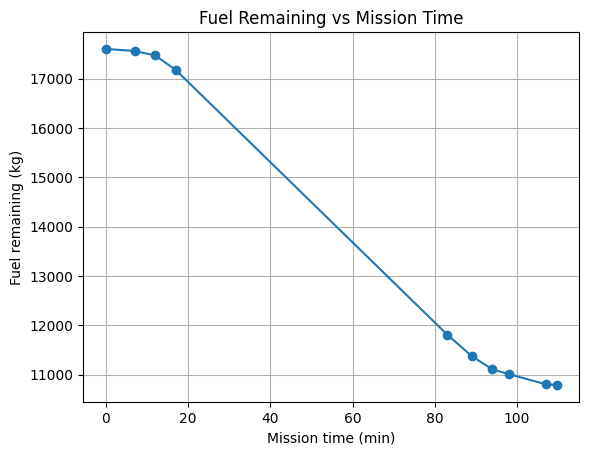

In [ ]:
# Cell 11: Fuel remaining vs mission time (minutes)
import numpy as np, pandas as pd, matplotlib.pyplot as plt

df = df_range.copy()
df["t_min_end"] = df["Duration_min_flown"].cumsum()
df["fuel_end"]  = df["Fuel_left_kg"]

plt.figure()
plt.plot(df["t_min_end"], df["fuel_end"], marker="o")
plt.xlabel("Mission time (min)")
plt.ylabel("Fuel remaining (kg)")
plt.title("Fuel Remaining vs Mission Time")
plt.grid(True)
plt.show()


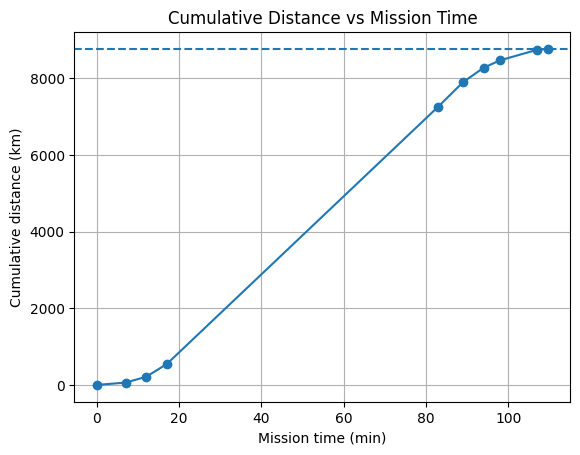

In [ ]:
# Cell 12: Cumulative distance vs time with target line
import matplotlib.pyplot as plt

df = df_range.copy()
df["dist_km_cum"] = df["Distance_km"].cumsum()
df["t_min_end"]   = df["Duration_min_flown"].cumsum()

plt.figure()
plt.plot(df["t_min_end"], df["dist_km_cum"], marker="o")
plt.axhline(8772.0, linestyle="--")
plt.xlabel("Mission time (min)")
plt.ylabel("Cumulative distance (km)")
plt.title("Cumulative Distance vs Mission Time")
plt.grid(True)
plt.show()


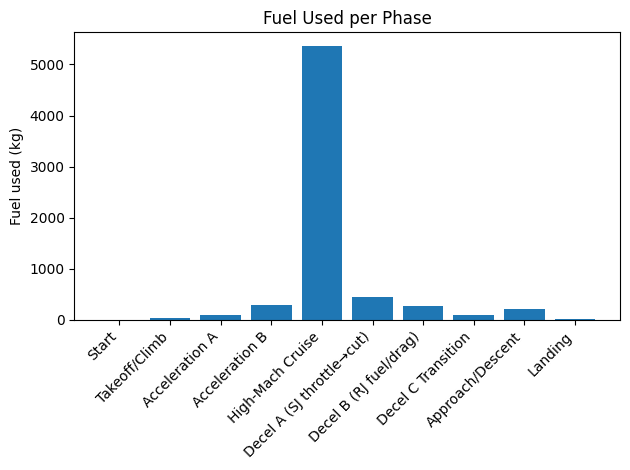

In [ ]:
# Cell 13: Per-phase fuel used (kg)
import matplotlib.pyplot as plt
ph = df_range["Phase"].astype(str)
vals = df_range["Fuel_used_kg"].astype(float)

plt.figure()
plt.bar(ph, vals)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Fuel used (kg)")
plt.title("Fuel Used per Phase")
plt.tight_layout()
plt.show()


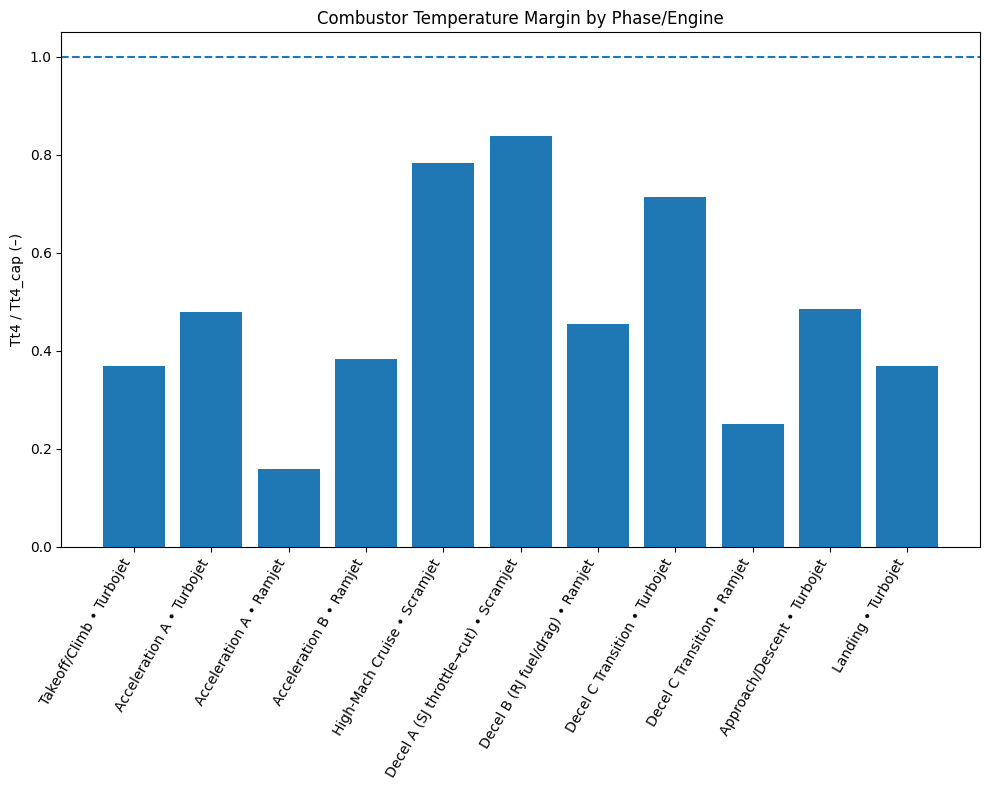

In [ ]:
# Cell 15: Tt4/Tt4_cap by phase and engine
import matplotlib.pyplot as plt

adf = audit_df.copy()
labels = adf["Phase"] + " • " + adf["Engine"]
vals = adf["Tt4/Tt4_cap"].astype(float)

plt.figure(figsize=(10,8))
plt.bar(labels, vals)
plt.xticks(rotation=60, ha="right")
plt.axhline(1.0, linestyle="--")
plt.ylabel("Tt4 / Tt4_cap (–)")
plt.title("Combustor Temperature Margin by Phase/Engine")
plt.tight_layout()
plt.show()

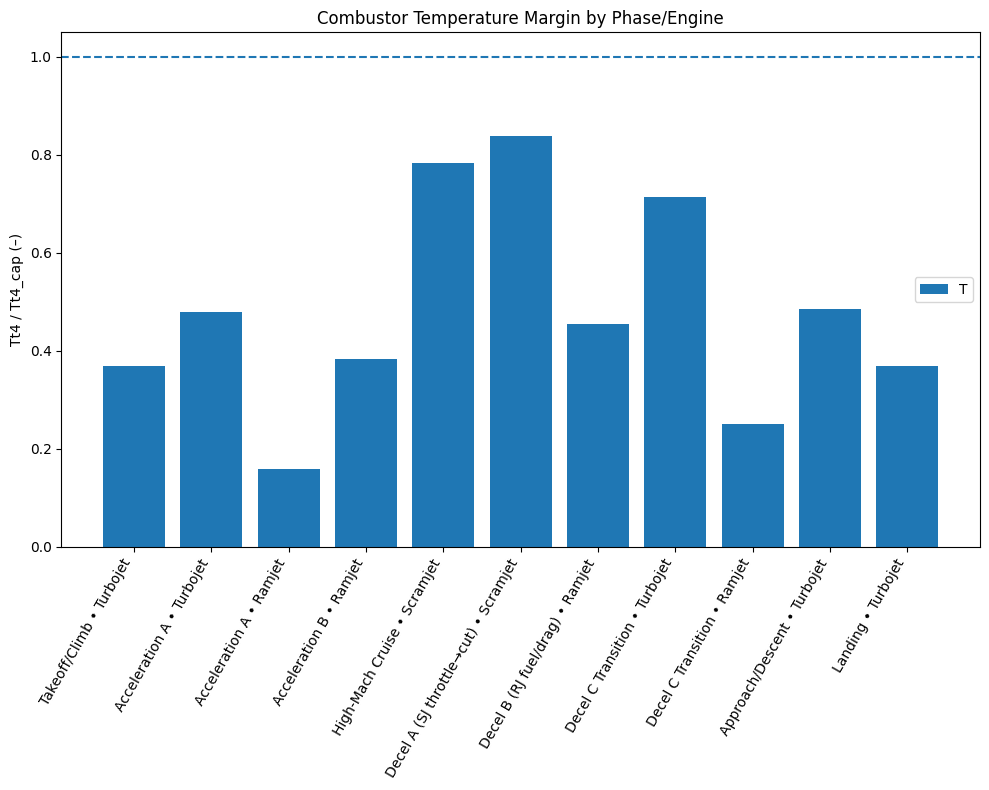

In [ ]:
# Cell 15: Tt4/Tt4_cap by phase and engine
import matplotlib.pyplot as plt

adf = audit_df.copy()
labels = adf["Phase"] + " • " + adf["Engine"]
vals = adf["Tt4/Tt4_cap"].astype(float)

plt.figure(figsize=(10,8))
plt.bar(labels, vals)
plt.legend("Tt4_cap set to .95Tt4_stoich")
plt.xticks(rotation=60, ha="right")
plt.axhline(1.0, linestyle="--")
plt.ylabel("Tt4 / Tt4_cap (–)")
plt.title("Combustor Temperature Margin by Phase/Engine")
plt.tight_layout()
plt.show()


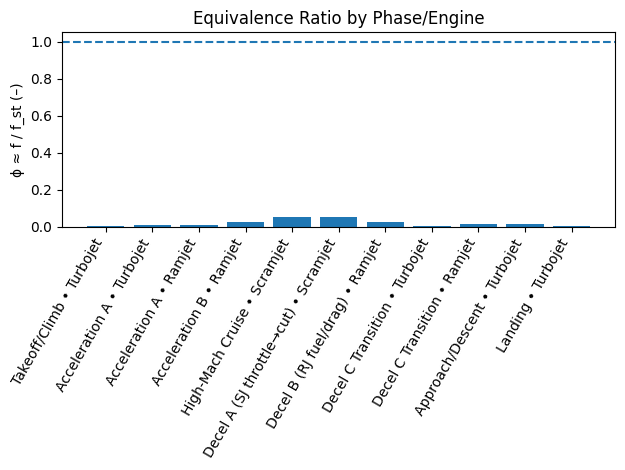

In [ ]:
# Cell 16: Equivalence ratio (phi ≈ f/f_st) by phase/engine
import matplotlib.pyplot as plt

adf = audit_df.copy()
labels = adf["Phase"] + " • " + adf["Engine"]
vals = adf["phi≈f/f_st"].astype(float)

plt.figure()
plt.bar(labels, vals)
plt.xticks(rotation=60, ha="right")
plt.axhline(1.0, linestyle="--")
plt.ylabel("ϕ ≈ f / f_st (–)")
plt.title("Equivalence Ratio by Phase/Engine")
plt.tight_layout()
plt.show()


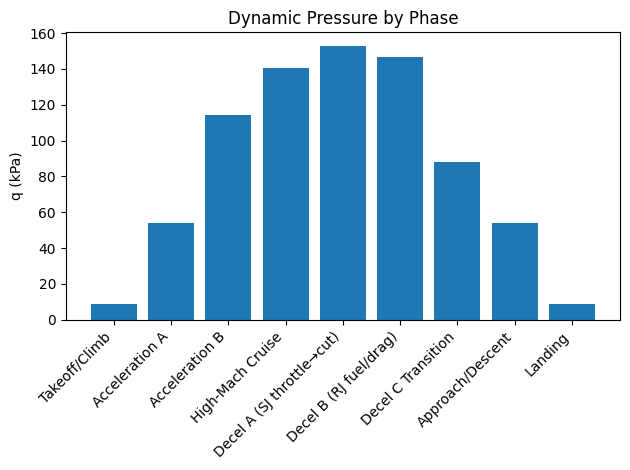

In [ ]:
# Cell 17: Dynamic pressure q by phase
import matplotlib.pyplot as plt
rows = []
for name, Mmid, hmid, mode in phases:
    T, p, rho, a = std_atm(hmid)
    V = Mmid * a
    q = 0.5 * rho * V * V / 1000.0  # kPa
    rows.append((name, q))
qdf = pd.DataFrame(rows, columns=["Phase","q_kPa"])

plt.figure()
plt.bar(qdf["Phase"], qdf["q_kPa"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("q (kPa)")
plt.title("Dynamic Pressure by Phase")
plt.tight_layout()
plt.show()


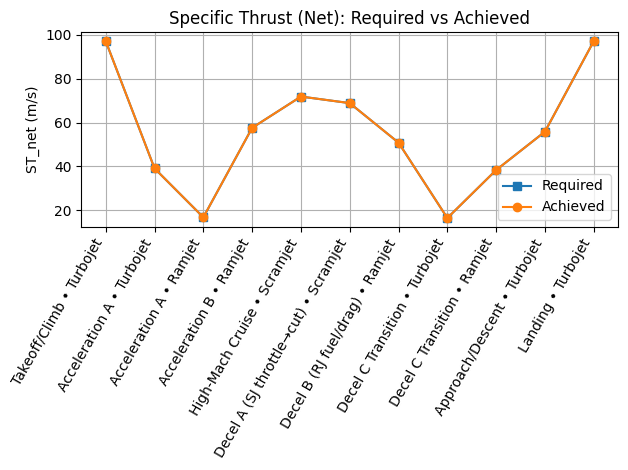

In [ ]:
# Cell 18: ST_net (achieved vs required) per engine-phase
import matplotlib.pyplot as plt

adf = audit_df.copy()
labels = adf["Phase"] + " • " + adf["Engine"]
req = adf["ST_net_req (m/s)"].astype(float).to_numpy()
ach = adf["ST_net_ach (m/s)"].astype(float).to_numpy()

plt.figure()
idx = np.arange(len(labels))
plt.plot(idx, req, marker="s", label="Required")
plt.plot(idx, ach, marker="o", label="Achieved")
plt.xticks(idx, labels, rotation=60, ha="right")
plt.ylabel("ST_net (m/s)")
plt.title("Specific Thrust (Net): Required vs Achieved")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


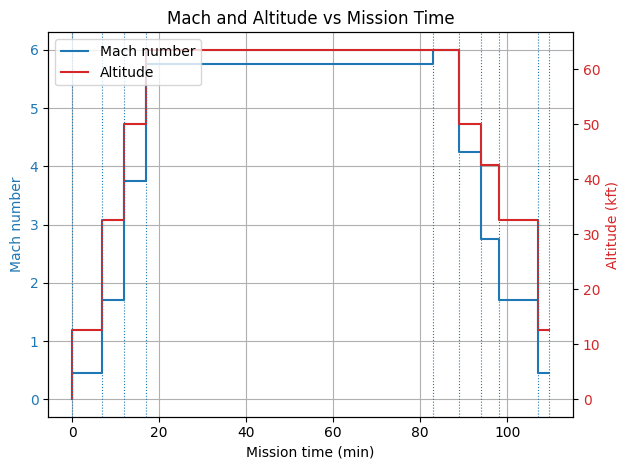

In [ ]:
# Mach (left) and Altitude (right, kft) vs Mission Time (min)
import pandas as pd, numpy as np, matplotlib.pyplot as plt

# Build time edges from flown durations
df = df_range.copy().reset_index(drop=True)
# Ensure we include the start row; compute phase end times
t_end = df["Duration_min_flown"].cumsum().to_numpy()
t_start = np.concatenate(([0.0], t_end[:-1]))
t_mid = 0.5*(t_start + t_end)

# Pull Mach/altitude per phase from df (which reflects actual flown phases)
M_list   = df["M"].to_list()
h_kft    = (df["h_kft"]).to_list()


# For step plotting, repeat each value at start and end
# The 'Start' row has 0 duration, so its Mach and altitude are only relevant at t=0
t_plot = np.repeat(np.stack([t_start, t_end], axis=1), repeats=1, axis=0).ravel(order="C")
M_plot = np.repeat(M_list, 2)
h_plot = np.repeat(h_kft, 2)

fig, ax1 = plt.subplots()
ax1.step(t_plot, M_plot, where="post", color='tab:blue', label='Mach number') # Added color and label
ax1.set_xlabel("Mission time (min)")
ax1.set_ylabel("Mach number", color='tab:blue') # Added color
ax1.tick_params(axis='y', labelcolor='tab:blue') # Added color
ax1.set_title("Mach and Altitude vs Mission Time")
ax1.grid(True)

ax2 = ax1.twinx()
ax2.step(t_plot, h_plot, where="post", color='tab:red', label='Altitude') # Added color and label
ax2.set_ylabel("Altitude (kft)", color='tab:red') # Added color
ax2.tick_params(axis='y', labelcolor='tab:red') # Added color

# Optional: vertical phase boundaries
for t in t_end:
    plt.axvline(t, linestyle=":", linewidth=0.8)

# Added legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')


plt.tight_layout()
plt.show()

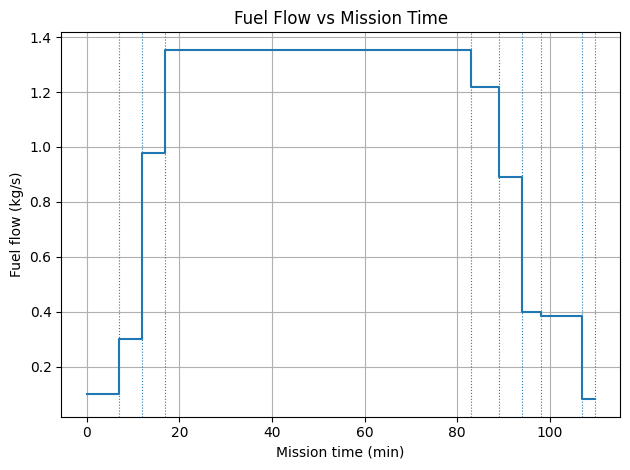

In [ ]:
# Total fuel flow (kg/s) vs Mission Time (min)
import pandas as pd, numpy as np, matplotlib.pyplot as plt

df = df_range.copy().reset_index(drop=True)
has_start = (str(df.loc[0,"Phase"]).lower().startswith("start"))
rows_use = df.iloc[1:] if has_start else df

t_end = rows_use["Duration_min_flown"].cumsum().to_numpy()
t_start = np.concatenate(([0.0], t_end[:-1]))
ff = rows_use["Fuel_rate_kgps"].astype(float).to_numpy()

t_plot = np.repeat(np.stack([t_start, t_end], axis=1), repeats=1, axis=0).ravel(order="C")
ff_plot = np.repeat(ff, 2)

plt.figure()
plt.step(t_plot, ff_plot, where="post", label="Total fuel flow")
plt.xlabel("Mission time (min)")
plt.ylabel("Fuel flow (kg/s)")
plt.title("Fuel Flow vs Mission Time")
plt.grid(True)

# Optional phase boundaries
for t in t_end:
    plt.axvline(t, linestyle=":", linewidth=0.8)

plt.tight_layout()
plt.show()


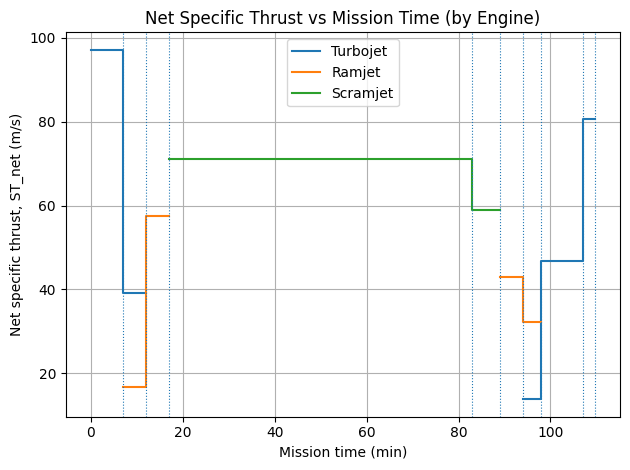

In [ ]:
# Net specific thrust (m/s) vs Mission Time, one line per engine (Turbojet/Ramjet/Scramjet)
import pandas as pd, numpy as np, matplotlib.pyplot as plt

df = df_range.copy().reset_index(drop=True)
has_start = (str(df.loc[0,"Phase"]).lower().startswith("start"))
rows_use = df.iloc[1:] if has_start else df

# Build time edges
t_end = rows_use["Duration_min_flown"].cumsum().to_numpy()
t_start = np.concatenate(([0.0], t_end[:-1]))

# Parse per-engine ST_net from the "Details" column
# Each Details item is a list of tuples: (engine, share, f_i, mdot_i, ST_req_i, ST_net_achieved)
engines = ["Turbojet","Ramjet","Scramjet"]
st_by_engine = {e: [] for e in engines}

for _, row in rows_use.iterrows():
    # default NaNs (engine not active)
    st_map = {e: np.nan for e in engines}
    for tup in row["Details"]:
        eng, frac, f_i, mdot_i, ST_req_i, ST_net_ach = tup
        st_map[eng] = float(ST_net_ach)
    for e in engines:
        st_by_engine[e].append(st_map[e])

# Step-plot sequences
t_plot = np.repeat(np.stack([t_start, t_end], axis=1), repeats=1, axis=0).ravel(order="C")

plt.figure()
for e in engines:
    vals = np.array(st_by_engine[e], dtype=float)
    vals_plot = np.repeat(vals, 2)
    plt.step(t_plot, vals_plot, where="post", label=e)

plt.xlabel("Mission time (min)")
plt.ylabel("Net specific thrust, ST_net (m/s)")
plt.title("Net Specific Thrust vs Mission Time (by Engine)")
plt.grid(True)
plt.legend()

# Optional phase boundaries
for t in t_end:
    plt.axvline(t, linestyle=":", linewidth=0.8)

plt.tight_layout()
plt.show()


In [ ]:
# Cell: η_overall + Fuel usage per phase/engine (robust; uses df_range["Details"])
import pandas as pd, numpy as np

LHV = 120e6  # J/kg for LH2

# Map Phase -> (M, h_m) from your 'phases' list
phase_state = {name: (M, h_m) for (name, M, h_m, mode) in phases}

rows = []
# Skip any "Start" row
rng = df_range if str(df_range.iloc[0]["Phase"]).lower() != "start" else df_range.iloc[1:]

for _, r in rng.iterrows():
    phase = r["Phase"]
    dt = float(r["Duration_min_flown"]) * 60.0  # s
    details = r["Details"] or []
    if phase not in phase_state:
        # If your df_range has truncated phases, skip those not in 'phases'
        continue
    M, h_m = phase_state[phase]
    T, p, rho, a = std_atm(h_m)  # your existing function
    V0 = M * a

    for (eng, frac, f_i, mdot_i, ST_req_i, ST_net_ach) in details:
        mdot_f = f_i * mdot_i                        # kg/s
        fuel_used = mdot_f * dt                      # kg
        thrust_N = ST_net_ach * mdot_i               # N (use achieved)
        P_thrust = thrust_N * V0                     # W
        P_chem   = mdot_f * LHV                      # W
        eta_overall = (P_thrust / P_chem) if P_chem > 0 else np.nan

        rows.append({
            "Phase": phase,
            "Engine": eng,
            "η_overall": eta_overall,
            "Fuel_used_kg": fuel_used
        })

eta_df = pd.DataFrame(rows)

# Add percentage of total fuel used (across all phases & engines in df_range)
total_fuel = eta_df["Fuel_used_kg"].sum()
eta_df["%_of_total_fuel"] = 100.0 * eta_df["Fuel_used_kg"] / total_fuel if total_fuel > 0 else np.nan

display(eta_df.round(4))
eta_df.round(4).to_csv("eta_df.csv")


,Phase,Engine,η_overall,Fuel_used_kg,%_of_total_fuel
0,Takeoff/Climb,Turbojet,0.8191,41.7345,0.6130
1,Acceleration A,Turbojet,0.6231,66.7919,0.9810
2,Acceleration A,Ramjet,0.3265,23.4105,0.3439
3,Acceleration B,Ramjet,0.6264,293.6207,4.3127
4,High-Mach Cruise,Scramjet,0.6892,5361.6925,78.7524
5,Decel A (SJ throttle→cut),Scramjet,0.6918,438.0824,6.4345
6,Decel B (RJ fuel/drag),Ramjet,0.6601,267.5205,3.9293
7,Decel C Transition,Turbojet,0.7063,11.5557,0.1697
8,Decel C Transition,Ramjet,0.5273,84.2711,1.2378
9,Approach/Descent,Turbojet,0.6184,206.7049,3.0361


In [ ]:
# Patch η_overall for subsonic turbojet phases (Takeoff/Climb, Landing)
import numpy as np
import pandas as pd

LHV = 120e6         # J/kg (LH2)
g0  = 9.80665       # m/s^2
L_over_D = 5.88     # keep consistent with your mission cell

# Build Phase -> (M, h_m) from your schedule
phase_state = {name: (M, h_m) for (name, M, h_m, mode) in phases}

# Work on a copy of your existing eta_df (the table you showed)
eta_filled = eta_df.copy()

# We need phase-start mass to compute W. Reconstruct from cumulative fuel burned.
# Use df_range in flown order (skip "Start" if present).
rng = df_range if str(df_range.iloc[0]["Phase"]).lower() != "start" else df_range.iloc[1:]
m0 = 40_000.0  # kg, your total mass at start
cum_fuel_before = 0.0

# Make a quick lookup: phase -> (mass_at_start, details, duration_s)
phase_book = {}
for _, r in rng.iterrows():
    phase = r["Phase"]
    duration_s = float(r["Duration_min_flown"]) * 60.0
    phase_book[phase] = (m0 - cum_fuel_before, r["Details"] or [], duration_s)
    cum_fuel_before += float(r["Fuel_used_kg"])

targets = {"Takeoff/Climb", "Landing"}  # phases to patch

rows_to_update = eta_filled["Phase"].isin(targets)
for idx, r in eta_filled[rows_to_update].iterrows():
    phase = r["Phase"]
    # pull Mach/alt
    if phase not in phase_state or phase not in phase_book:
        continue
    M, h_m = phase_state[phase]
    m_start, details, dt = phase_book[phase]

    # ambient and speed
    T, p, rho, a = std_atm(h_m)
    V0 = M * a
    W  = m_start * g0

    # Required thrust (use same model as Cell 10; add ROC term here if you’ve implemented it)
    T_required = W / L_over_D

    # total fuel flow from details tuples: (engine, share, f_i, mdot_i, ST_req_i, ST_net_ach)
    mdot_f_total = 0.0
    for (eng, frac, f_i, mdot_i, ST_req_i, ST_net_ach) in details:
        mdot_f_total += f_i * mdot_i

    P_chem   = mdot_f_total * LHV
    P_thrust = T_required * V0
    eta_calc = (P_thrust / P_chem) if P_chem > 0 else np.nan

    # write back
    eta_filled.loc[idx, "η_overall"] = eta_calc

display(eta_filled.round(4))
eta_filled.to_csv("eta_filled.csv")


,Phase,Engine,η_overall,Fuel_used_kg,%_of_total_fuel
0,Takeoff/Climb,Turbojet,0.8191,41.7345,0.6130
1,Acceleration A,Turbojet,0.6231,66.7919,0.9810
2,Acceleration A,Ramjet,0.3265,23.4105,0.3439
3,Acceleration B,Ramjet,0.6264,293.6207,4.3127
4,High-Mach Cruise,Scramjet,0.6892,5361.6925,78.7524
5,Decel A (SJ throttle→cut),Scramjet,0.6918,438.0824,6.4345
6,Decel B (RJ fuel/drag),Ramjet,0.6601,267.5205,3.9293
7,Decel C Transition,Turbojet,0.7063,11.5557,0.1697
8,Decel C Transition,Ramjet,0.5273,84.2711,1.2378
9,Approach/Descent,Turbojet,0.6184,206.7049,3.0361


In [ ]:
#